**To do: add classifier accuracy measure, add dedicated validation data**

In [1]:
# DANN pytorch implementation based on https://github.com/fungtion/DANN

In [36]:
# Imports we will use
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
#from torchsummary import summary
from sklearn.metrics import r2_score

# For matplotlib
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)
from functools import partial
# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [40]:
from scipy import stats

In [3]:
# Define reversal layer for DANN
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [38]:
# Load data function
def create_dataloader(img_path, metadata_path, batch_size):
    '''
    Creates dataloader for training, reserving the last 1000 images for validation/testing
    '''
    data = np.load(img_path).squeeze()
    data_train = torch.tensor(data[:-10000])
    temp = data[-10000:]
    data_test = torch.tensor(temp[:5000])
    data_valid = torch.tensor(temp[5000:])
    
    metadata = pd.read_csv(metadata_path)
    labels = metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()
    labels_train = torch.tensor(labels[:-10000])
    temp_labels = labels[-10000:]
    labels_test = torch.tensor(temp_labels[:5000])
    labels_valid = torch.tensor(temp_labels[5000:])
    
    '''
    data_train.cuda()
    data_test.cuda()
    data_valid.cuda()
    labels_train.cuda()
    labels_test.cuda()
    labels_valid.cuda()
    '''
    
    train_dataset = TensorDataset(data_train, labels_train)
    test_dataset = TensorDataset(data_test, labels_test)
    valid_dataset = TensorDataset(data_valid, labels_valid)
    
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
    return train_dataloader, test_dataloader, valid_dataloader

In [39]:
# Load in data
source_img_path = '/Users/zhaoyifan/Desktop/0314source_dataset/CONFIGURATION_1_images.npy'
target_img_path = '/Users/zhaoyifan/Desktop/0314target_dataset/CONFIGURATION_1_images.npy'
source_meta = '/Users/zhaoyifan/Desktop/0314source_dataset/CONFIGURATION_1_metadata.csv'
target_meta = '/Users/zhaoyifan/Desktop/0314target_dataset/CONFIGURATION_1_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_valid_dataloader = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_valid_dataloader = create_dataloader(target_img_path, target_meta, batch_size)

In [6]:
# Define data visualization function
def visualize_data(data):
    '''
    visualizes 16 random images from dataset
    '''
    #get random indices
    x = np.empty(1)
    i = 1

    while i < 16:
        example_num = int(random.randrange(0, len(data[0:])))
        if example_num != x[i-1]:
            x = np.append(x, [example_num])
            i += 1
        
    #plot the examples for source
    fig1=plt.figure(figsize=(8,8))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.axis("off")
    
        example_indices = int(x[i])
    
        example_image = np.squeeze(data[example_indices:(example_indices + 1)]) #change band by switching 0:1 to 1:2 or 2:3
    
        plt.imshow(example_image, aspect='auto', cmap='viridis')

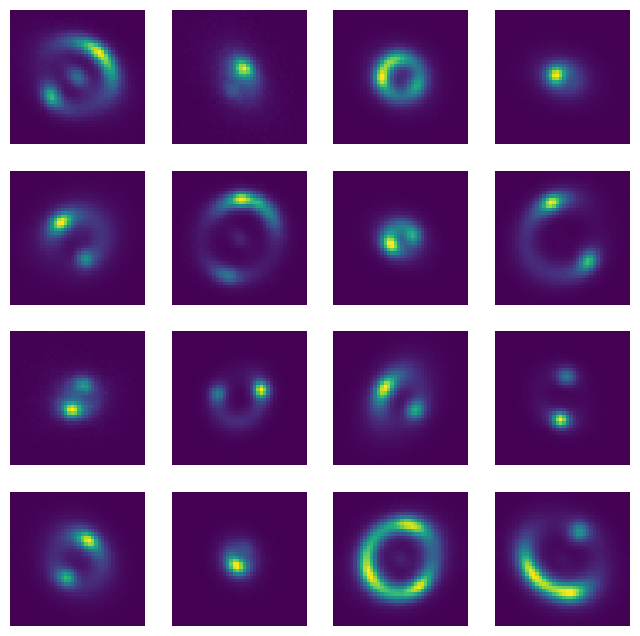

In [7]:
# Visualize source data
visualize_data(source_data)

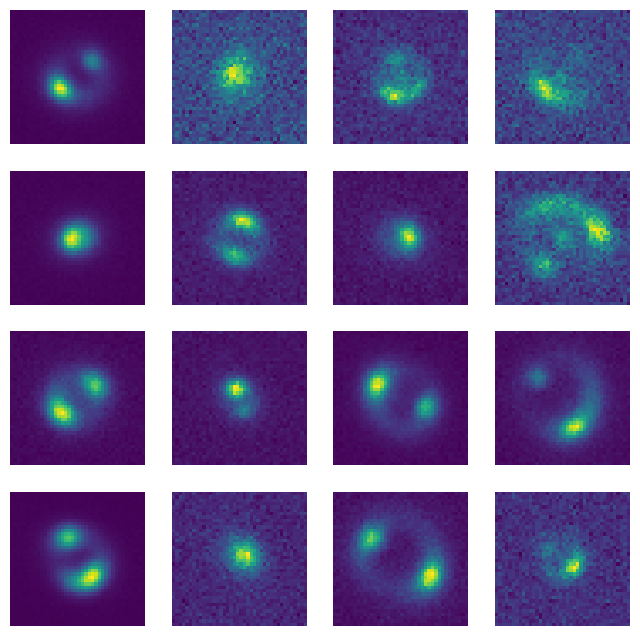

In [8]:
# Visualize target data
visualize_data(target_data)

In [27]:
# Define and initialize model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('r_relu1', nn.ReLU(True))
        #self.regressor.add_module('r_fc2', nn.Linear(in_features=128, out_features=64))
        #self.regressor.add_module('r_relu2', nn.ReLU(True))
        self.regressor.add_module('r_fc3', nn.Linear(in_features=128, out_features=1))
        
    def forward(self, x):
        x = x.view(-1, 1, 40, 40)
        
        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1)
        
        return estimate, features



In [28]:
class MMD_loss(nn.Module):
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [29]:
def gaussian_kernel_matrix(x, y, sigmas):
    '''
    Gaussian RBF kernel to be used in MMD
    Args:
    x,y: latent features
    sigmas: free parameter that determins the width of the kernel
    Returns:
    '''
    beta = 1. / (2. * (torch.unsqueeze(sigmas, 1)))
    dist = compute_pairwise_distances(x, y)
    s = torch.matmul(beta, dist.contiguous().view(1, -1))
    return torch.sum(torch.exp(-s), 0).view(*dist.size())


def compute_pairwise_distances(x, y):
    if not x.dim() == y.dim() == 2:
        raise ValueError('Both inputs should be matrices.')
    if x.size(1) != y.size(1):
        raise ValueError('The number of features should be the same.')

    norm = lambda x: torch.sum(torch.pow(x, 2), 1)
    return torch.transpose(norm(torch.unsqueeze(x, 2) - torch.transpose(y, 0, 1)), 0, 1)


def maximum_mean_discrepancy(x, y, kernel=gaussian_kernel_matrix):
    '''
    Calculate the matrix that includes all kernels k(xx), k(y,y) and k(x,y)
    '''
    cost = torch.mean(kernel(x, x))
    cost += torch.mean(kernel(y, y))
    cost -= 2 * torch.mean(kernel(x, y))
    # We do not allow the loss to become negative.
    cost = torch.clamp(cost, min=0.0)
    return cost


def mmd_distance(hs, ht):
    '''
    Maximum Mean Discrepancy - MMD
    Args:
        hs: source domain embeddings
        ht: target domain embeddings
    Returns:
        MMD value
    '''
    sigmas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5,
              10, 15, 20, 25, 30, 35, 100, 1e3, 1e4, 1e5, 1e6]
    gaussian_kernel = partial(gaussian_kernel_matrix,
                              sigmas=torch.Tensor(sigmas).double().to(device))
    loss_value = maximum_mean_discrepancy(hs, ht, kernel=gaussian_kernel)
    return torch.clamp(loss_value, min=1e-4)

In [30]:
# Define training loop
# To do - add domain classifier accuracy measure
def train_loop(source_dataloader, target_dataloader, model, regressor_loss_fn, classifier_loss_fn, optimizer, n_epoch, epoch):
   
    domain_error = 0
    domain_classifier_accuracy = 0
    estimator_error = 0
    score_list = np.array([])

    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    data_source_iter = iter(source_dataloader)
    data_target_iter = iter(target_dataloader)
        
    i = 0
    while i < len_dataloader:
            
        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        
        # Source Training
        
        data_source = next(data_source_iter)
        X, y = data_source
        X = X.float()
        #X = X.cuda()
        #y = y.cuda()
        
        model.zero_grad()
        batch_size = len(y)
        
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
        #
        #domain_label = domain_label.cuda()
        
        estimate_output, domain_output_source = model(X)
        
        estimate_loss = regressor_loss_fn(estimate_output, y)
        
        # Target Training
        
        data_target = next(data_target_iter)
        X_target, _ = data_target
        X_target = X_target.float()
        #X_target = X_target.cuda()
        
        batch_size = len(X_target)
        
        _, domain_output_target = model(X_target)
        domain_loss = mmd_distance(domain_output_source.double(), domain_output_target.double())
        
        loss = estimate_loss + domain_loss*1.
        loss.backward()
        optimizer.step()
        
        # Update values
            
        domain_error += domain_loss.item()
        #domain_classifier_accuracy += 
        estimator_error += estimate_loss.item()
        score = r2_score(y.cpu().detach().numpy(), estimate_output.cpu().detach().numpy())
        score_list = np.append(score_list, score)

        i += 1
        
    score = np.mean(score_list)
    domain_error = domain_error / (len_dataloader)
    estimator_error /= len_dataloader
    
    return [domain_error, estimator_error, score]

In [31]:
# Define testing loop
# To do - add domain classifier accuracy measure
def test_loop(source_dataloader, target_dataloader, model, regressor_loss_fn, classifier_loss_fn, n_epoch, epoch):
    
    with torch.no_grad():
    
        len_dataloader = min(len(source_dataloader), len(target_dataloader))
        data_source_iter = iter(source_dataloader)
        data_target_iter = iter(target_dataloader)
        
        domain_classifier_error = 0
        domain_classifier_accuracy = 0
        estimator_error = 0
        estimator_error_target = 0
        score_list = np.array([])
        score_list_target = np.array([])
        
        i = 0
        while i < len_dataloader:

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
        
            # Source Testing
        
            data_source = next(data_source_iter)
            X, y = data_source
            X = X.float()
            #X = X.cuda()
            #y = y.cuda()
        
            batch_size = len(y)
        
            #domain_label = torch.zeros(batch_size)
            #domain_label = domain_label.long()
            #domain_label = domain_label.cuda()
        
            estimate_output, domain_output = model(X)
        
            estimate_loss = regressor_loss_fn(estimate_output, y)
            #domain_loss_source = classifier_loss_fn(domain_output, domain_label)
        
            # Target Testing
        
            data_target = next(data_target_iter)
            X_target, y_target = data_target
            X_target = X_target.float()
            #X_target = X_target.cuda()
            #y_target = y_target.cuda()
        
            batch_size = len(X_target)
        
            #domain_label = torch.ones(batch_size)
            #domain_label = domain_label.long()
            #domain_label = domain_label.cuda()
        
            estimate_output_target, domain_output = model(X_target)
            
            estimate_loss_target = regressor_loss_fn(estimate_output_target, y_target)
            #domain_loss_target = classifier_loss_fn(domain_output, domain_label)
            
            # Update values
            
           # domain_classifier_error += domain_loss_source.item()
            #domain_classifier_error += domain_loss_target.item()
            #domain_classifier_accuracy += 
            estimator_error += estimate_loss.item()
            estimator_error_target += estimate_loss_target.item()
            score = r2_score(y.cpu(), estimate_output.cpu())
            score_list = np.append(score_list, score)
            score_target = r2_score(y_target.cpu(), estimate_output_target.cpu())
            score_list_target = np.append(score_list_target, score_target)

            i += 1
            
        score = np.mean(score_list)
        score_target = np.mean(score_list_target)
        #classifier_error = domain_classifier_error / (len_dataloader * 2)
        estimator_error /= len_dataloader
        estimator_error_target /= len_dataloader
    classifier_error = 1
    return [classifier_error, estimator_error, estimator_error_target, score, score_target]

In [32]:
# Initialize dictionary for training stats
model = NeuralNetwork()
learning_rate = 6e-5
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss()
classifier_loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#da_loss = MMD_loss()
#da_loss = mmd_distance()
# Hyper parameter presets
batch_size = 32
epochs = 15
stats = {'train_domain_classifier_error':[], 
             'train_estimator_error':[],
             'train_score':[],
             'val_domain_classifier_error':[], 
             'val_estimator_error':[], 
             'val_estimator_error_target':[], 
             'val_score':[], 
             'val_score_target':[]}

# Train
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    vals = train_loop(source_train_dataloader, target_train_dataloader, model, 
               regressor_loss_fn, classifier_loss_fn, optimizer, epochs, i)
    
    vals_validate = test_loop(source_valid_dataloader, target_valid_dataloader, 
                     model, regressor_loss_fn, classifier_loss_fn, epochs, i)
    
    to_print = (
        f'Train Estimator Error = {vals[1]}\n'
        f'Train Estimator R2 Score = {vals[2]:.4f}\n'
        f'Train Domain Classifier Error = {vals[0]}\n'
        f'Validation Source Estimator Error = {vals_validate[1]}\n'
        f'Validation Source R2 Score = {vals_validate[3]:.4f}\n'
        f'Validation Target Estimator Error = {vals_validate[2]}\n'
        f'Validation Target R2 Score = {vals_validate[4]:.4f}\n'
        f'Validation Domain Classifier Error = {vals_validate[0]}\n'
    )
    
    print(to_print)
    
    #vals += vals_validate
    
    #for i, stat in enumerate(stats):
    #    stats[stat].append(vals[i])
        

Epoch 1
-------------------------------
Train Estimator Error = 0.14474340322241186
Train Estimator R2 Score = 0.7088
Train Domain Classifier Error = 1.055022840106094
Validation Source Estimator Error = 0.03241147671582972
Validation Source R2 Score = 0.9330
Validation Target Estimator Error = 0.2629661270577437
Validation Target R2 Score = 0.4775
Validation Domain Classifier Error = 1

Epoch 2
-------------------------------
Train Estimator Error = 0.02540961123108864
Train Estimator R2 Score = 0.9486
Train Domain Classifier Error = 0.9917384262356316
Validation Source Estimator Error = 0.020179821338480824
Validation Source R2 Score = 0.9584
Validation Target Estimator Error = 0.11174418945695944
Validation Target R2 Score = 0.7746
Validation Domain Classifier Error = 1

Epoch 3
-------------------------------
Train Estimator Error = 0.017186115369945763
Train Estimator R2 Score = 0.9650
Train Domain Classifier Error = 0.9790689265961119
Validation Source Estimator Error = 0.0169377

In [33]:
#torch.save(model.state_dict(), 'D:/SL CNN/source_dataset/30_epoch_model.pt')
torch.save(model.state_dict(), '/Users/zhaoyifan/Desktop/model15.pt')

In [16]:
import csv

In [34]:
model = NeuralNetwork()
model.load_state_dict(torch.load('/Users/zhaoyifan/Desktop/model15.pt'))
model.eval()

NeuralNetwork(
  (feature): Sequential(
    (f_conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (f_relu1): ReLU(inplace=True)
    (f_bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (f_conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (f_relu2): ReLU(inplace=True)
    (f_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (f_conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (f_relu3): ReLU(inplace=True)
    (f_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (r_fc1): Linear(in_features=800, ou

In [21]:
with open("D:/SL CNN/source_dataset/30_epoch_stats.csv", "w") as outfile:
   
   # pass the csv file to csv.writer.
    writer = csv.writer(outfile)
     
    # convert the dictionary keys to a list
    key_list = list(stats.keys())
    # find the length of the key_list
    limit = len(key_list)
     
    # the length of the keys corresponds to
    # no. of. columns.
    writer.writerow(stats.keys())
     
    # iterate each column and assign the
    # corresponding values to the column
    for i in range(30):
        writer.writerow([stats[x][i] for x in key_list])

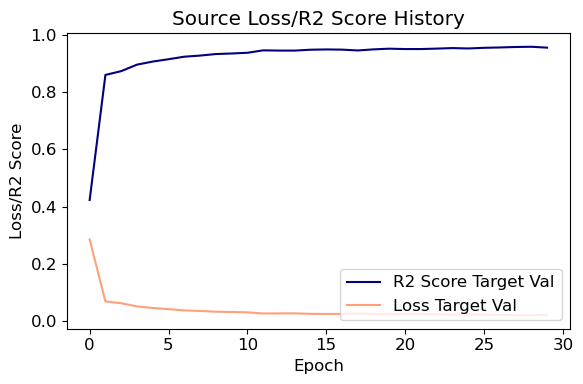

In [22]:
# Plot target val

plt.rc('font', size=12) 

estimator_error_target = stats['train_estimator_error']
score_target = stats['train_score']

epochs = list(range(30))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_val_lacc = axis1.plot(epochs, score_target, 'navy', label="R2 Score Target Val")

plot1_val_loss = axis1.plot(epochs, estimator_error_target, 'lightsalmon', label="Loss Target Val")


plots = plot1_val_lacc + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/R2 Score')
plt.title("Source Loss/R2 Score History")
plt.tight_layout()
axis1.legend(loc='lower right')

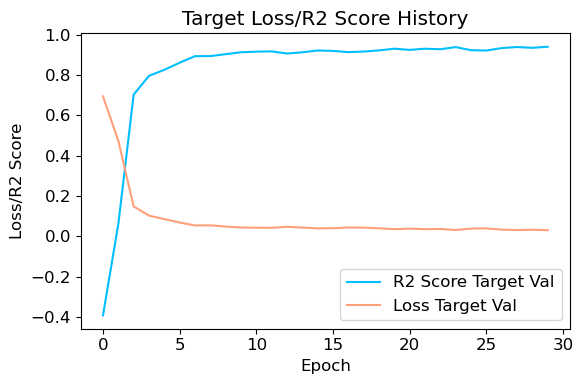

In [23]:
# Plot target val

plt.rc('font', size=12) 

estimator_error_target = stats['val_estimator_error_target']
score_target = stats['val_score_target']

epochs = list(range(30))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_val_lacc = axis1.plot(epochs, score_target, 'deepskyblue', label="R2 Score Target Val")

plot1_val_loss = axis1.plot(epochs, estimator_error_target, 'lightsalmon', label="Loss Target Val")


plots = plot1_val_lacc + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/R2 Score')
plt.title("Target Loss/R2 Score History")
plt.tight_layout()
axis1.legend(loc='lower right')

In [43]:
from scipy.stats import gaussian_kde

Source R2 Score is 0.8934


Text(0.5, 1.0, 'Residuals')

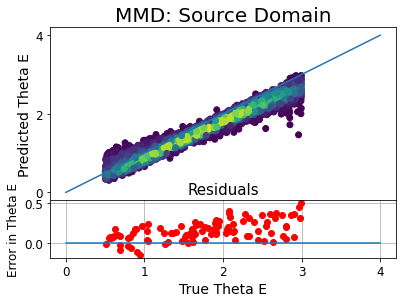

In [41]:
# Test Source
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X)
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)
        
score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

fig1 = plt.figure(1)
frame1 = fig1.add_axes((.1,.3,.8,.6))
xy = np.vstack([true,preds])
z = stats.gaussian_kde(xy)(xy)
plt.scatter(true, preds, c=z)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
#plt.colorbar()

plt.ylabel('Predicted Theta E', fontsize=14);
plt.yticks(fontsize = 12)
plt.rc('font', size=20)
plt.title('MMD: Source Domain', fontsize=20)

difference = true[:100] - preds[:100]
frame2=fig1.add_axes((.1,.1,.8,.2))        
plt.plot(true[:100],difference,'or')
plt.plot(line[:100], np.zeros((100)))
plt.grid()
plt.xlabel('True Theta E', fontsize=14)
plt.ylabel('Error in Theta E', fontsize=12)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.title('Residuals', fontsize=15)

Target R2 Score is 0.5320


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

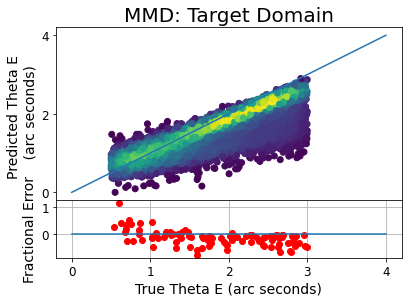

In [43]:
# Test target
preds = np.array([])
true = np.array([])
score_list = np.array([])
with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X)
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)
score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')
fig1 = plt.figure(1)
frame1 = fig1.add_axes((.1,.3,.8,.6))
xy = np.vstack([true,preds])
z = stats.gaussian_kde(xy)(xy)
plt.scatter(true, preds, c=z)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
#plt.colorbar()
plt.ylabel('Predicted Theta E \n (arc seconds)', fontsize=14);
plt.yticks(fontsize = 12)
plt.rc('font', size=20)
plt.title('MMD: Target Domain', fontsize=20)
difference = (preds[:100] - true[:100]) / true[:100]
frame2=fig1.add_axes((.1,.1,.8,.2))
plt.plot(true[:100],difference,'or')
plt.plot(line[:100], np.zeros((100)))
plt.grid()
plt.xlabel('True Theta E (arc seconds)', fontsize=14)
plt.ylabel('Fractional Error', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
#plt.title('Residuals', fontsize=15)

In [ ]:
# Plot source training/val

plt.rc('font', size=12) 

train_estimator_error = stats['train_estimator_error']
train_score = stats['train_score']

val_estimator_error = stats['train_estimator_error']
val_score = stats['train_score']

epochs = list(range(epochs))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, train_score, 'navy', label='R2 Score Train')
plot1_val_lacc = axis1.plot(epochs, val_score, 'deepskyblue', label="R2 Score Val")

plot1_loss = axis1.plot(epochs, train_estimator_error, 'red', label='Loss Train')
plot1_val_loss = axis1.plot(epochs, val_estimator_error, 'lightsalmon', label="Loss Val")


plots = plot1_val_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/R2 Score')
plt.title("Training Source Loss/R2 Score History DANN")
plt.tight_layout()
axis1.legend(loc='lower right')

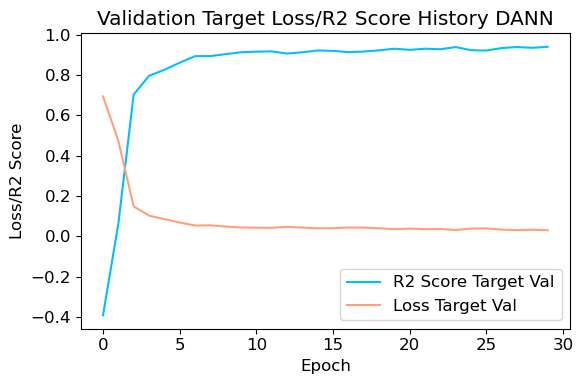

In [61]:
# Plot target val

plt.rc('font', size=12) 

estimator_error_target = stats['val_estimator_error_target']
score_target = stats['val_score_target']

epochs = list(range(30))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_val_lacc = axis1.plot(epochs, score_target, 'deepskyblue', label="R2 Score Target Val")

plot1_val_loss = axis1.plot(epochs, estimator_error_target, 'lightsalmon', label="Loss Target Val")


plots = plot1_val_lacc + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/R2 Score')
plt.title("Validation Target Loss/R2 Score History DANN")
plt.tight_layout()
axis1.legend(loc='lower right')

In [ ]:
# Plot domain classifier training loss

train_domain_classifier_error = stats['train_domain_classifier_error']
val_domain_classifier_error = stats['val_domain_classifier_error']

epochs = list(range(epochs))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, train_domain_classifier_error, 'navy', label='Loss Train')

plot1_val_loss = axis1.plot(epochs, val_domain_classifier_error, 'lightsalmon', label="Loss Val")

plots = plot1_lacc + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss')
plt.title("Domain Classifier Validation Loss History")
plt.tight_layout()
axis1.legend(loc='lower right')

In [24]:
# Define and initialize model
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(in_features=32*5*5, out_features=100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(in_features=100, out_features=2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))
        
        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=1))
        
    def forward(self, x, alpha):
        x = x.view(-1, 1, 40, 40)
        
        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        reverse_features = ReverseLayerF.apply(features, alpha)
        domain = self.domain_classifier(reverse_features)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1)
        
        return features

model2 = NeuralNetwork2().cuda()

In [25]:
model2.load_state_dict(torch.load('D:/SL CNN/source_dataset/30_epoch_model.pt'))

<All keys matched successfully>

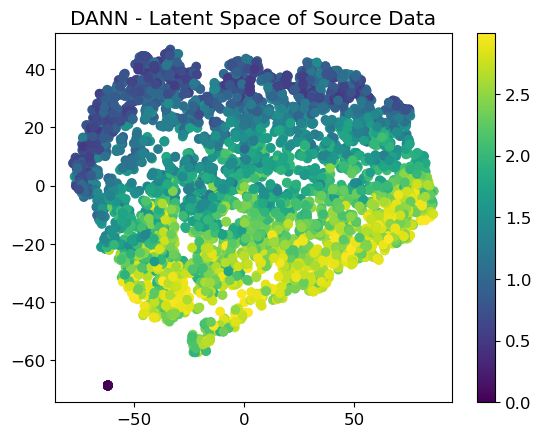

In [46]:
latents = np.zeros((len(source_test_dataloader)*32-1, 32*5*5))
categories = np.zeros((len(source_test_dataloader)*32-1))
with torch.no_grad():
    for batch, (X, y) in enumerate(source_test_dataloader):
        if len(X) < 32:
            break
        X = X.float()
        features = model2(X.cuda(), 1)
        latents[batch*32:batch*32+32] = features.cpu().numpy()
        categories[batch*32:batch*32+32] = y.cpu().numpy()
from sklearn.manifold import TSNE
latent_2d = TSNE(n_components=2).fit_transform(latents)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=categories, cmap='viridis')
plt.colorbar()
plt.title('DANN - Latent Space of Source Data')
plt.show()

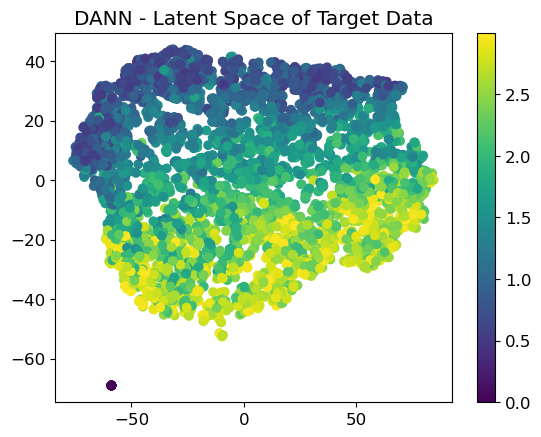

In [45]:
latents = np.zeros((len(target_test_dataloader)*32-1, 32*5*5))
categories = np.zeros((len(target_test_dataloader)*32-1))
with torch.no_grad():
    for batch, (X, y) in enumerate(target_test_dataloader):
        if len(X) < 32:
            break
        X = X.float()
        features = model2(X.cuda(), 1)
        latents[batch*32:batch*32+32] = features.cpu().numpy()
        categories[batch*32:batch*32+32] = y.cpu().numpy()
        
from sklearn.manifold import TSNE
latent_2d = TSNE(n_components=2).fit_transform(latents)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=categories, cmap='viridis')
plt.colorbar()
plt.title('DANN - Latent Space of Target Data')
plt.show()

In [47]:
print(len(target_test_dataloader))

157


In [48]:
# Load data function
def create_dataloader(img_path, metadata_path, batch_size):
    '''
    Creates dataloader for training, reserving the last 1000 images for validation/testing
    '''
    data = np.load(img_path).squeeze()
    data_train = torch.tensor(data[:-10000])
    data_test = torch.tensor(data[-10000:])
    
    metadata = pd.read_csv(metadata_path)
    labels = metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()
    labels_train = torch.tensor(labels[:-10000])
    labels_test = torch.tensor(labels[-10000:])
    
    data_train.cuda()
    data_test.cuda()
    labels_train.cuda()
    labels_test.cuda()
    
    train_dataset = TensorDataset(data_train, labels_train)
    test_dataset = TensorDataset(data_test, labels_test)
    
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
    
    return train_dataloader, test_dataloader, data

In [49]:
# Load in data
source_img_path = 'D:/SL CNN/source_dataset/CONFIGURATION_1_images.npy'
target_img_path = 'D:/SL CNN/target_dataset/CONFIGURATION_1_images.npy'
source_meta = 'D:/SL CNN/source_dataset/CONFIGURATION_1_metadata.csv'
target_meta = 'D:/SL CNN/target_dataset/CONFIGURATION_1_metadata.csv'

source_train_dataloader, source_test_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

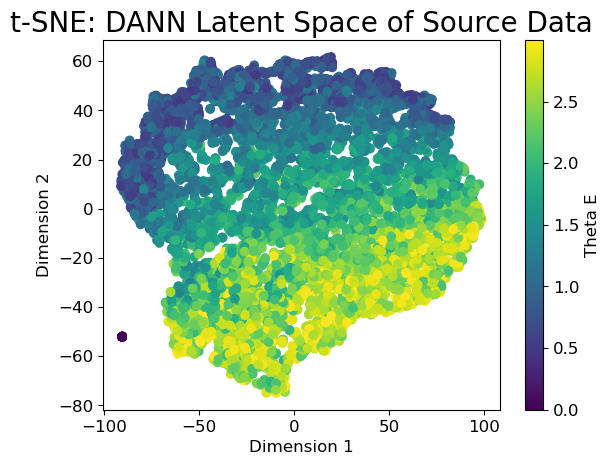

In [58]:
latents = np.zeros((len(source_test_dataloader)*32-1, 32*5*5))
categories = np.zeros((len(source_test_dataloader)*32-1))
with torch.no_grad():
    for batch, (X, y) in enumerate(source_test_dataloader):
        if len(X) < 32:
            break
        X = X.float()
        features = model2(X.cuda(), 1)
        latents[batch*32:batch*32+32] = features.cpu().numpy()
        categories[batch*32:batch*32+32] = y.cpu().numpy()
from sklearn.manifold import TSNE
latent_2d = TSNE(n_components=2).fit_transform(latents)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=categories, cmap='viridis')
cb = plt.colorbar()
cb.set_label('Theta E', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.title('t-SNE: DANN Latent Space of Source Data', fontsize=20)
plt.show()

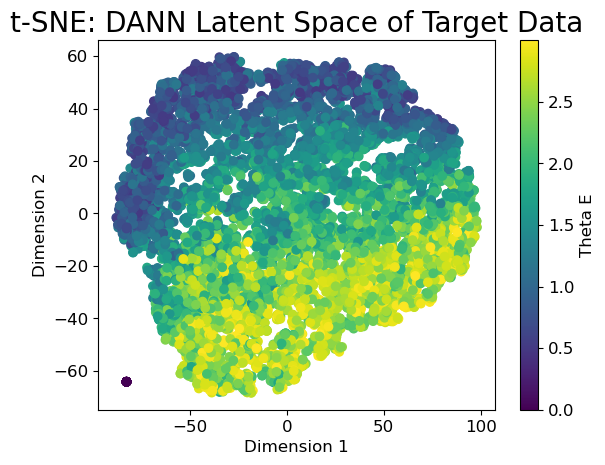

In [59]:
latents = np.zeros((len(target_test_dataloader)*32-1, 32*5*5))
categories = np.zeros((len(target_test_dataloader)*32-1))
with torch.no_grad():
    for batch, (X, y) in enumerate(target_test_dataloader):
        if len(X) < 32:
            break
        X = X.float()
        features = model2(X.cuda(), 1)
        latents[batch*32:batch*32+32] = features.cpu().numpy()
        categories[batch*32:batch*32+32] = y.cpu().numpy()
        
from sklearn.manifold import TSNE
latent_2d = TSNE(n_components=2).fit_transform(latents)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=categories, cmap='viridis')
cb = plt.colorbar()
cb.set_label('Theta E', fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.title('t-SNE: DANN Latent Space of Target Data', fontsize=20)
plt.show()